<a href="https://colab.research.google.com/github/ganeevsingh18/CV_assignment1/blob/main/q2_2021389_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import copy

import csv
import random

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib
%matplotlib inline

from PIL import Image
!pip install wandb

import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torchvision.models as models

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#MAKING DATASET

Mounted drive onto colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Opened a folder via folder path

In [ ]:
import os

folder_path='/content/drive/MyDrive/cv dataset'
contents=os.listdir(folder_path)

print(contents)


['roe_deer', 'dog', 'brown_bear', 'birds', 'amur_leopard', 'people', 'wild_boar', 'amur_tiger', 'sika_deer', 'black_bear', '.ipynb_checkpoints']


I want to create a csv file containing

[image-classification]

I have a made a dictionary that contains {class: [[path,class]...]}

In [ ]:
directory = folder_path

dict={}
i=1

for root in os.listdir(directory):
  path=os.path.join(directory,root)
  for file in os.listdir(path):
    if root not in dict:
      dict[root]=[[os.path.join(path,file),root]]
    else:
      dict[root].append([os.path.join(path,file),root])
    i+=1

using sklearn model selection have made stratified random split

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import copy

# Initialize dictionaries for train, validation, and test data
train_dict = {}
validation_dict = {}
test_dict = {}

# Determine the ratio of data to split (0.7, 0.1, 0.2)
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

# Used inbuilt StratifiedShuffleSplit of sklearn
splitter = StratifiedShuffleSplit(n_splits=1, test_size=(validation_ratio + test_ratio), random_state=42)

#made dictionaries of TRAIN,VALIDATE and TEST
for class_name, class_data in dict.items():

    class_labels = [sample[1] for sample in class_data]


    class_data_array = np.array(class_data)


    for train_idx, rest_idx in splitter.split(class_data_array, class_labels):
        train_dict[class_name] = class_data_array[train_idx].tolist()
        rest_data = class_data_array[rest_idx]

        validation_test_split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42)
        for validation_idx, test_idx in validation_test_split.split(rest_data, rest_data[:, 1]):
            validation_dict[class_name] = rest_data[validation_idx].tolist()
            test_dict[class_name] = rest_data[test_idx].tolist()

print("Train Dict Size:", sum(len(class_data) for class_data in train_dict.values()))
print("Validation Dict Size:", sum(len(class_data) for class_data in validation_dict.values()))
print("Test Dict Size:", sum(len(class_data) for class_data in test_dict.values()))


Train Dict Size: 9040
Validation Dict Size: 1291
Test Dict Size: 2590


csv_array contains [index,image_path,classification]

In [ ]:
import csv
import random


#function that converts the dictionaries formed into csv
def dict_to_csv(data_dict,csv_file_path):
    header = ['Path', 'Class']
    path_root_list = []

    for sample_data in data_dict.values():
        path_root_list.extend(sample_data)

    # Randomize the list
    random.shuffle(path_root_list)


    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(path_root_list)

forming csv files for training,validation and testing

In [ ]:
training_csv = '/content/drive/My Drive/cv csv/training_csv'
validation_csv='/content/drive/My Drive/cv csv/validation_csv'
testing_csv='/content/drive/My Drive/cv csv/testing_csv'

dict_to_csv(train_dict,training_csv)
dict_to_csv(validation_dict,validation_csv)
dict_to_csv(test_dict,testing_csv)

Importing Dependancies

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib
%matplotlib inline


created customImageDataset class as per pyTorch documentation

In [ ]:
from PIL import Image

#2: 1 a) Downloading dataset

Made a customImageDatset using tochivsion

A per documentation it should contain __init__,__len__,__getitem__

after reading csv file with pandas, all 3 functions are defined

In [ ]:

#defining a class to label dictionary
#because the dataloader outputs the names of classes rather than numbers of classification
class_to_label = {
    'amur_leopard':0,
    'amur_tiger':1,
    'birds':2,
    'black_bear':3,
    'brown_bear':4,
    'dog':5,
    'people':6,
    'roe_deer':7,
    'sika_deer':8,
    'wild_boar':9
}

Using pytorch library to create dataloaders each for training,validation and testing

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = pd.read_csv(img_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir.iloc[idx][0]
        image = Image.open(img_path)
        label = class_to_label[self.img_dir.iloc[idx][1]]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a specific size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])


#2: 1 b) Creating Dataloaders

Creating dataloaders for each TRAIN,VALIDATE and TEST

using the 3 csv files I had created and the above CUstomImagedataset class

Used pytorch dataloader to form dataloader with batch_size=32

In [ ]:
num_workers=8
batch_size=128

In [ ]:
wildlife_training_dataset= CustomImageDataset(img_dir=training_csv,transform=transform)
train_loader= DataLoader(dataset=wildlife_training_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)


wildlife_validation_dataset= CustomImageDataset(img_dir=validation_csv,transform=transform)
validation_loader= DataLoader(dataset=wildlife_validation_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

wildlife_testing_dataset= CustomImageDataset(img_dir=testing_csv,transform=transform)
test_loader= DataLoader(dataset=wildlife_testing_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [ ]:
# Iterate over the data loader once
for batch_data, batch_labels in train_loader:
    print(f"Batch data type: {type(batch_data)}, Batch labels type: {type(batch_labels)}")
    break  # Break after the first batch to avoid printing for all batches

Batch data type: <class 'torch.Tensor'>, Batch labels type: <class 'torch.Tensor'>


I aldready created dictionaries for each training,validation and testing datasets

In [ ]:
#using training and validation datsets to visualise data distribution
# %%script echo skipping
import matplotlib.pyplot as plt

#create a function that plots a bar graph based on the dictionary
def plot_class_distribution(data_dict,label):

    labels=[]
    sizes=[]
    for keys in data_dict:
      labels.append(keys)
      sizes.append(len(data_dict[keys]))

    # Create a bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(labels,sizes, color='skyblue')
    plt.xlabel(label)
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
print(validation_dict)

{'roe_deer': [['/content/drive/MyDrive/cv dataset/roe_deer/0555_rd_n_crop00_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0152_rd_d_crop01_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0721_rd_n_crop01_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0723_rd_n_crop01_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0883_rd_n_crop00_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0571_rd_d_crop00_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/1277_rd_n_crop00_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0438_rd_n_crop00_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0888_rd_n_crop00_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/1352_rd_n_crop00_detections.jpg', 'roe_deer'], ['/content/drive/MyDrive/cv dataset/roe_deer/0226_rd_d_crop00_dete

#2: 1 c) Visualise Data Distribution

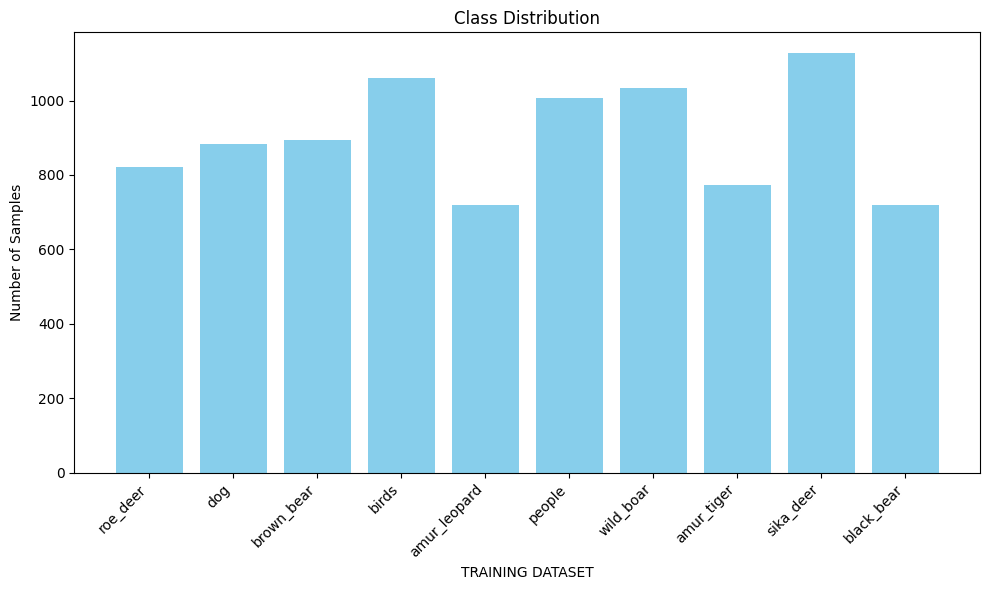

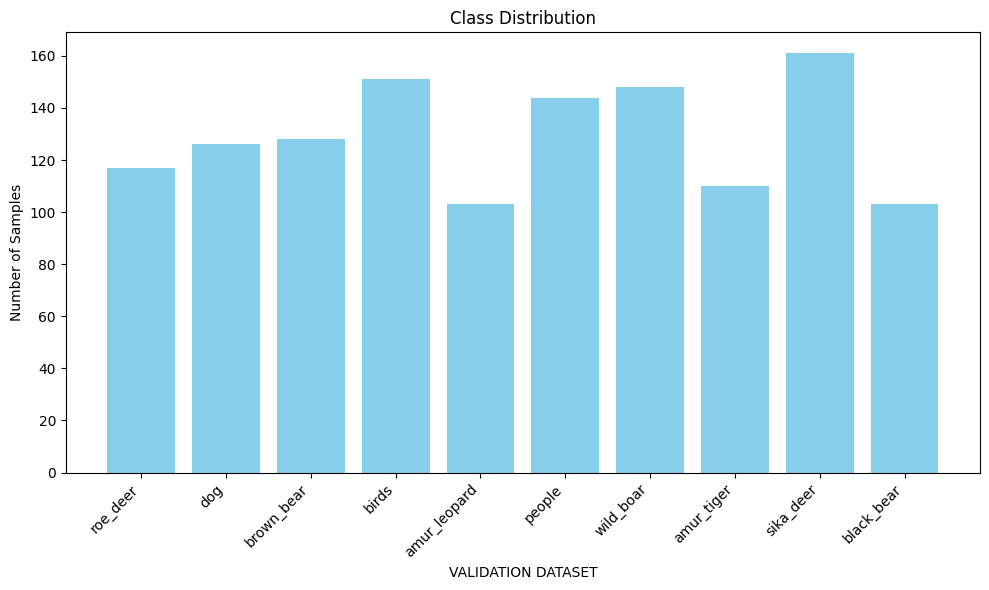

In [ ]:
# %%script echo skipping
plot_class_distribution(train_dict,"TRAINING DATASET")
plot_class_distribution(validation_dict,"VALIDATION DATASET")

The validation set is hidden because we don't want the mdoel to know that,
we will reveal the distributions at validation time when the model is trained

using [given colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb#scrollTo=nhIDda1mHUvF) writing the following code

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Creating a small toy_dataset for checking codes, I will show output for the big dataset in final demo

In [ ]:
#I have a very big dict called train_dict
#I am creating a small toy dataset from it



num_samples = 10


toy_data_dict = {}
for class_label, samples_list in train_dict.items():

    random.shuffle(samples_list)
    toy_samples = samples_list[:num_samples]

    toy_data_dict[class_label] = toy_samples

toy_csv= '/content/drive/MyDrive/cv csv/toy_csv'
dict_to_csv(toy_data_dict,toy_csv)


wildlife_toy_dataset= CustomImageDataset(img_dir=toy_csv,transform=transform)
toy_loader= DataLoader(dataset=wildlife_toy_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [ ]:
toy_validation_dict = {}
for class_label, samples_list in train_dict.items():

    random.shuffle(samples_list)
    toy_samples = samples_list[:num_samples]

    toy_validation_dict[class_label] = toy_samples

toy_validation_csv= '/content/drive/MyDrive/cv csv/validation_csv'
dict_to_csv(toy_validation_dict,toy_validation_csv)


wildlife_toy_validation= CustomImageDataset(img_dir=toy_validation_csv,transform=transform)
toy_validation_loader= DataLoader(dataset=wildlife_toy_validation,batch_size=batch_size,shuffle=True,num_workers=num_workers)

Data visualisation

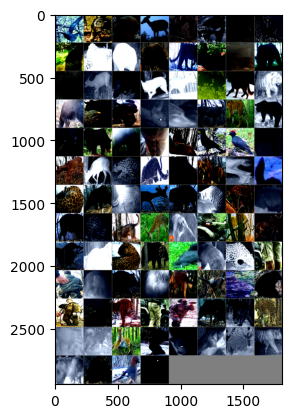

In [ ]:
# %%script echo skipping

import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# Assuming you have a DataLoader 'dataloader' containing images
# First, define a function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if the data was normalized
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterate through your DataLoader to display a batch of images
dataiter = iter(toy_loader)
images, labels = next(dataiter)

# Show images in the batch
imshow(torchvision.utils.make_grid(images))


#2: 2 a) Creating CNN architecture


1. CNN defined

used inbuolt pytorch CNN model and made specifications as i wanted to

In [ ]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First Convolution Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Second Convolution Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolution Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Classification Head
        self.fc = nn.Linear(25088, 10)

    def forward(self, x):
        # First Convolution Layer
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second Convolution Layer
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Third Convolution Layer
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Classification Head
        x = self.fc(x)

        return x

# Create an instance of the CNN model
cnn_model = CNN()

# Print the model architecture

print(cnn_model)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)


In [ ]:
import torch.nn as nn
import torch.optim as optim

2. Hyperparameters cell

In [ ]:
# %%script echo skipping
cnn_model=cnn_model.to('cuda')

In [ ]:

# %%script echo skipping


#defining hyperparamters for the use of CNN model
# Hyperparameters
hyperparameters={"batch_size":32,"learning_rate":0.001,"num_epochs":10}

# set up model and data
#I have aldready created model object and dataloader object
#model object name: cnn_model
#dataloader object name: train_loader

#have to use cross-entropy loss
#use adam optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=hyperparameters["learning_rate"])
scheduler = torch.optim.lr_scheduler


# 2: 2 b) Training function

Defined a training function
will train it with wandb in next cell

In [ ]:
#started a new model
# wandb.init(project="new-classification-model", name="run_name")

In [ ]:
def train(model, data_loader, validation_loader, criterion, optimizer, scheduler, hyperparameters):
    wandb.watch(model, criterion, log="all", log_freq=10)
    for epoch in range(hyperparameters["num_epochs"]):

        # TRAINING PHASE
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for batch_data, batch_labels in data_loader:
            # Zero the gradients
            optimizer.zero_grad()
            batch_data = batch_data.to('cuda')
            batch_labels = batch_labels.to('cuda')  # Move labels to GPU

            # Forward pass
            outputs = model(batch_data)

            # Compute loss
            loss = criterion(outputs, batch_labels)

            # Backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate running loss
            running_loss += loss.item()

        # Calculate average loss for the epoch
        average_loss = running_loss / len(data_loader)
        # wandb.log({"train_loss": average_loss}, step=epoch+1)

        # VALIDATION PHASE
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_data, batch_labels in validation_loader:
                batch_data = batch_data.to('cuda')  # Move data to CUDA device
                batch_labels = batch_labels.to('cuda')  # Move labels to GPU

                output = model(batch_data)
                loss = criterion(output, batch_labels)
                val_loss += loss.item()

                _, predicted = torch.max(output, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        val_accuracy = correct / total

        # Log validation losses to wandb
        wandb.log({"epoch": epoch + 1, "train_loss": average_loss, "val_loss": avg_val_loss, "val_accuracy": val_accuracy})

    # Training complete
    print("Training finished.")



In [ ]:
# %%script echo skipping
#training

with wandb.init(project="CV ASSIGNMNET 2", name="train_CNN"):
  train(cnn_model, train_loader,validation_loader,criterion=criterion, optimizer=optimizer,scheduler=scheduler,hyperparameters=hyperparameters)



Training finished.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▆▄▂▃▂▁▂▂▃
epoch,10
train_loss,0.38833
val_accuracy,0.64988
val_loss,1.30564


#2: 2 d) Testing Function


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#this function takes in a dataloader and find the accuracy of the cnn model on that dataloader
#It reports f1 score, accuracy and confusion matrix
def test(model, dataloader, hyperparameters):

    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels in dataloader:
            batch_data = batch_data.to('cuda')
            outputs = model(batch_data)

            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
            batch_labels = batch_labels.cpu().numpy()

            predictions.extend(predicted_labels)
            labels.extend(batch_labels)
        # We have all predictions in predictions list and the real labels as labels
        # All are mapped with iterator aka prediction[i]'s correct label is labels[i]

        # Using inbuilt sklearn metrics to compute accuracy, f1, confusion
        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='weighted')
        confusion = confusion_matrix(labels, predictions)
        wandb.log({"test_accuracy": accuracy, "test_f1_score": f1, "confusion_matrix": confusion.tolist()})

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test F1-Score: {f1:.4f}")
        print("Confusion Matrix:")
        print(confusion)



In [ ]:
# %%script echo skipping
with wandb.init(project="CV ASSIGNMNET 2", name="test_validation_CNN"):
  test(cnn_model, validation_loader, hyperparameters)

Test Accuracy: 0.6499
Test F1-Score: 0.6491
Confusion Matrix:
[[ 76   8   5   1   2   1   2   5   3   0]
 [ 13  69   2   2   1   4   1   8   6   4]
 [  6   4 111   1   3   4   6   1   8   7]
 [  0   0   1  65  12   6   3   1   3  12]
 [  1   2   4  25  63  11   3   7   7   5]
 [  2   3   8   5   7  64   6   8  22   1]
 [  1   2   3   1   0  13 115   1   7   1]
 [  0   4   4   1   0  13   2  70  20   3]
 [ 10   9   6   4   2  18   7  14  85   6]
 [  1   2   3   6   4   1   1   1   8 121]]


test_accuracy,▁
test_f1_score,▁
test_accuracy,0.64988
test_f1_score,0.64911


In [ ]:
# %%script echo skipping
with wandb.init(project="CV ASSIGNMNET 2", name="test_test_CNN"):
  test(cnn_model, test_loader, hyperparameters)


Test Accuracy: 0.6772
Test F1-Score: 0.6770
Confusion Matrix:
[[165  11   6   2   2   3   3   9   5   0]
 [ 23 138   6   2   3   7   5  15  18   5]
 [ 13   6 233   3   1   9  15   4  12   8]
 [  3   6   3 133  21   7   2   4  10  17]
 [  2   4   7  48 136  10   4   8   8  29]
 [  7   8  14  12   4 148   9  17  27   7]
 [  7   8   6   5   6  18 222   4  11   1]
 [  3   5   4   1   1  14   5 160  32  11]
 [  7  10   8   3   5  35  12  44 192   7]
 [  2   1   5  15   6   8   4  16  12 227]]


test_accuracy,▁
test_f1_score,▁
test_accuracy,0.67722
test_f1_score,0.67698


In [ ]:
# %%script echo skipping
torch.save(cnn_model.state_dict(), 'model_weights.pth')
with wandb.init(project="CV ASSIGNMNET 2", name="save_CNN"):
  wandb.save('model_weights.pth')

In [ ]:



# Check if GPU is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Then move your model to the selected device


In [ ]:
class_to_label

{'amur_leopard': 0,
 'amur_tiger': 1,
 'birds': 2,
 'black_bear': 3,
 'brown_bear': 4,
 'dog': 5,
 'people': 6,
 'roe_deer': 7,
 'sika_deer': 8,
 'wild_boar': 9}

#2: 3 a) Pre-trained Resnet18 architecture


In [ ]:
# %%script echo skipping
import torchvision.models as models

model_resnet = models.resnet18(pretrained=True)
number_features= model_resnet.fc.in_features
model_resnet.fc = nn.Linear(number_features, 10 )
model_resnet = model_resnet.to('cuda')
#I have put 10 because we have 10 output classes, different animals


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=hyperparameters["learning_rate"])
scheduler = torch.optim.lr_scheduler


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Taken a pre-trained Resnet18 model

I aldready made a train fucntion that takes in any model, then does the forward pass, calculates the loss and does the backward pass

I'll use the same function again


Using the aldready made function to train the model
The model paramater that is passed in function is now changed to an object of ResNet model

In [ ]:
# %%script echo skipping
# wandb.init(project="new-classification-model", name="run_name")
  # train(cnn_model, toy_loader,toy_validation_loader,criterion=criterion, optimizer=optimizer,scheduler=scheduler,hyperparameters=hyperparameters)
with wandb.init(project="CV ASSIGNMNET 2", name="train_Resnet"):
  train(model_resnet, train_loader,validation_loader,criterion=criterion, optimizer=optimizer,scheduler=scheduler,hyperparameters=hyperparameters)

Training finished.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▄▄▂▆▆█▁█▆▆
val_loss,▂▂▃▁▃▂█▃▃▃
epoch,10
train_loss,0.08517
val_accuracy,0.79473
val_loss,0.78027


# 2: 3 b) Training vs Validation loss plots


The loss plots will be plotted in wandb dashboard: copy: them and write answer here

#2: 3 c) Testing Resnet18

Using the aldready made test function to test the function
The function will create the f1-score, accuracy and the confusion matrix

In [ ]:
# %%script echo skipping
# wandb.init(project="new-classification-model", name="run_name")

with wandb.init(project="CV ASSIGNMNET 2", name="test_RESNET"):
  test(model_resnet, test_loader, hyperparameters)

Test Accuracy: 0.8351
Test F1-Score: 0.8348
Confusion Matrix:
[[183  13   2   2   1   2   1   0   1   1]
 [  0 220   0   0   0   0   0   0   2   0]
 [  0  11 282   1   0   1   7   0   1   1]
 [  0   3   2 134  52   3   0   1   3   8]
 [  0  15   2  17 204   3   2   3   3   7]
 [  0  30   9   2   6 173   8  10  12   3]
 [  0   7   3   0   2   4 269   2   0   1]
 [  0   4   0   0   1   3   1 206  19   2]
 [  0  20  12   0   0   7   4  18 255   7]
 [  0  10  10   6  14   3   1   2  13 237]]


test_accuracy,▁
test_f1_score,▁
test_accuracy,0.83514
test_f1_score,0.83484


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#2: 3 d) Visualising tSNE plot

Visualising the feature represntation of the fine tuned Model and making tSNE plots

tSNE plots are basically converting the feature vector of higher dimensions into lower dimensions using Support Vector Machine and grouping algorithms

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


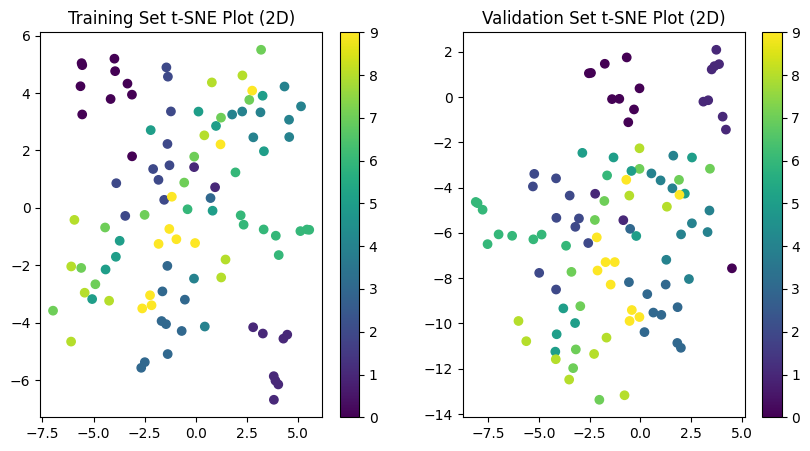

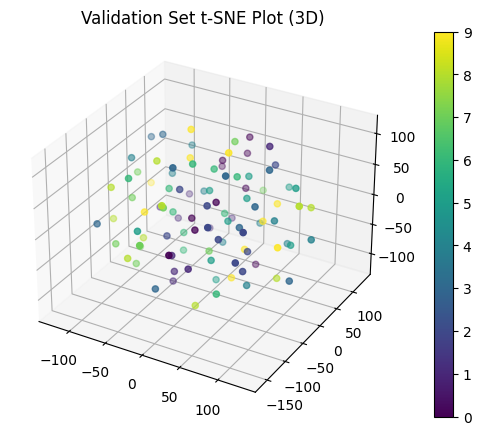

In [ ]:
import torch
from torchvision import models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Initialize ResNet-18 as the backbone
backbone = model_resnet
backbone = torch.nn.Sequential(*(list(backbone.children())[:-1]))  # Remove the last fully connected layer

# Function to extract feature vectors using the backbone
def extract_features(dataloader, backbone):
    features = []
    labels = []
    backbone.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            features.append(backbone(images).squeeze())
            labels.extend(targets.cpu().numpy())
    features = torch.cat(features, dim=0).cpu().numpy()
    labels = torch.tensor(labels)
    return features, labels

# Example usage with toy_loader (replace with your actual DataLoader)
train_features, train_labels = extract_features(toy_loader, backbone)
val_features, val_labels = extract_features(toy_loader, backbone)

# Perform t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
train_tsne_2d = tsne.fit_transform(train_features)
val_tsne_2d = tsne.fit_transform(val_features)

# Perform t-SNE for 3D visualization
tsne_3d = TSNE(n_components=3, random_state=42)
val_tsne_3d = tsne_3d.fit_transform(val_features)

# Visualize 2D t-SNE plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_tsne_2d[:, 0], train_tsne_2d[:, 1], c=train_labels, cmap='viridis')
plt.title('Training Set t-SNE Plot (2D)')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.scatter(val_tsne_2d[:, 0], val_tsne_2d[:, 1], c=val_labels, cmap='viridis')
plt.title('Validation Set t-SNE Plot (2D)')
plt.colorbar()
plt.show()

# Visualize 3D t-SNE plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(val_tsne_3d[:, 0], val_tsne_3d[:, 1], val_tsne_3d[:, 2], c=val_labels, cmap='viridis')
plt.title('Validation Set t-SNE Plot (3D)')
plt.colorbar(scatter)
plt.show()


Visualising how does standardizing tranform works on an image

IGNORE

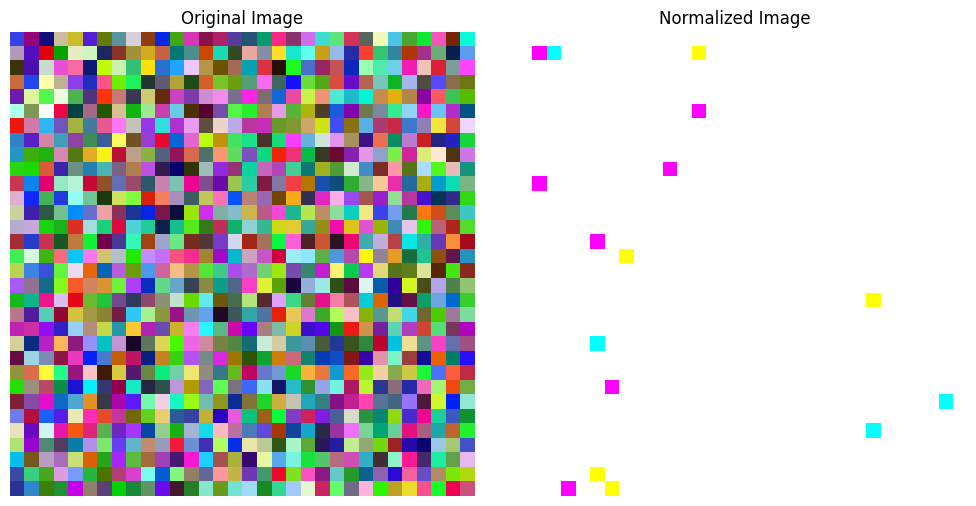

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Generate a random image tensor
H, W = 32, 32
img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

# Convert image tensor to float
img_float = img.float()

# Define the normalization parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the normalization transformation
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Apply normalization transformation
normalized_img = normalize_transform(img_float)

# Convert tensor to numpy array for visualization
original_img_np = img.numpy().transpose((1, 2, 0))
normalized_img_np = normalized_img.numpy().transpose((1, 2, 0))

# Plot original and normalized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Normalized Image')
plt.imshow(normalized_img_np)
plt.axis('off')

plt.tight_layout()
plt.show()



#2: 4 a) Data Augmentation techniques

DATA AUGMENTATION TECHNIQUES

I want to increase the dataset by changing the dataset a little
that could be either increasing brightness, rotate, flip or randomly crop etc.

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = pd.read_csv(img_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir.iloc[idx][0]
        image = Image.open(img_path).convert("RGB")


        # Apply additional transformations
        if self.additional_transform:
            image = self.additional_transform(image)

        label = class_to_label[self.img_dir.iloc[idx][1]]

        if self.transform:
            image = self.transform(image)


        return image, label


#defining transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a specific size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

I can add more data to the dataset train_loader and then train model on it

like i can take each image from given dataset, which is a csv file of ['image path',classification] in my case

Make images using augmentation techniques suppose
1. rotation
2. cropping
3. increasing brightness

and add paths of the new created images along with its classification to the train_loader csv file

Now i can make CustomDataset out of the csv file, then make a dataloader and train pretrained ResNet18 model on it

I have aldready created functions:
CustomImageDataset()
Dataloader()
train()

Considering I have limited Computation power, I am using inbuilt Augmentation techniques provided by Pytorch


In [ ]:
#Using 3 augmentation techniques:
#1. resizedcrop
#2. randomrotate
#3. color jitter


In [ ]:
old_transform=toy_loader.dataset.transform

#2: 4 b) Training pre-trained ResNet 18 on the augmented datasets

1. resizedcrop

In [ ]:
resized_crop_transform = transforms.Compose([
    transforms.Resize((256, 256)),            # Resize images to a larger size for cropping
    transforms.RandomCrop((224, 224)),        # Randomly crop images to the desired size
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize image data
])



In [ ]:
train_loader.dataset.transform=resized_crop_transform

In [ ]:
with wandb.init(project="CV ASSIGNMNET 2", name="training_cropped_resnet"):
  train(model_resnet, train_loader,validation_loader,criterion=criterion, optimizer=optimizer,scheduler=scheduler,hyperparameters=hyperparameters)

Training finished.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▅▅▇▅▇▇▇▇▁█
val_loss,▂▁▂▅▃▂▂▃█▁
epoch,10
train_loss,0.08809
val_accuracy,0.86832
val_loss,0.50794


2. Random rotate

In [ ]:
random_rotate_transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize images to a fixed size
    transforms.RandomRotation(degrees=30),     # Randomly rotate images by up to 30 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize image data
])

In [ ]:
train_loader.dataset.transform=random_rotate_transform

In [ ]:
with wandb.init(project="CV ASSIGNMNET 2", name="training_rotated_resnet"):
  train(model_resnet, train_loader,validation_loader,criterion=criterion, optimizer=optimizer,scheduler=scheduler,hyperparameters=hyperparameters)

Training finished.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▄▃▃▂▂▂▁▂
val_accuracy,▁▃▇▇▆▆▇█▇▇
val_loss,█▇▂▃▅▇▂▁▄▄
epoch,10
train_loss,0.04875
val_accuracy,0.86987
val_loss,0.68306


3. Colour jitter

In [ ]:
color_jitter_transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize images to a fixed size
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize image data
])


In [ ]:
train_loader.dataset.transform=color_jitter_transform

In [ ]:
with wandb.init(project="CV ASSIGNMNET 2", name="training_colorjitter_resnet"):
  train(model_resnet, train_loader,validation_loader,criterion=criterion, optimizer=optimizer,scheduler=scheduler,hyperparameters=hyperparameters)

Training finished.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▇▂▃▃▄▄▇▆█
val_loss,▄█▄▄▂▅▆▁▃▁
epoch,10
train_loss,0.00361
val_accuracy,0.90163
val_loss,0.42478


#2: 4 c) Check If overfitting?

#2: 4 d) Testing the new model

In [ ]:
with wandb.init(project="CV ASSIGNMNET 2", name="testing_Augmented_resnet"):
  test(model_resnet, validation_loader, hyperparameters)

Test Accuracy: 0.9016
Test F1-Score: 0.9013
Confusion Matrix:
[[ 97   1   3   0   0   0   0   0   1   1]
 [  0 106   0   0   0   2   0   1   1   0]
 [  0   0 142   1   2   1   1   1   3   0]
 [  0   0   0  87  11   2   1   0   0   2]
 [  1   0   0  12 105   2   0   2   3   3]
 [  1   0   5   2   1 106   2   1   5   3]
 [  0   0   2   0   2   0 138   1   0   1]
 [  0   0   1   0   0   2   0 109   4   1]
 [  1   0   1   0   2   5   1  11 134   6]
 [  0   1   2   1   1   0   0   1   2 140]]


test_accuracy,▁
test_f1_score,▁
test_accuracy,0.90163
test_f1_score,0.90135


In [ ]:
with wandb.init(project="CV ASSIGNMNET 2", name="testing_Augmented_resnet"):
  test(model_resnet, test_loader, hyperparameters)

Test Accuracy: 0.9193
Test F1-Score: 0.9193
Confusion Matrix:
[[201   2   2   0   1   0   0   0   0   0]
 [  0 211   0   0   2   2   2   1   3   1]
 [  2   0 288   0   3   3   4   0   0   4]
 [  0   0   2 173  20   1   0   0   5   5]
 [  1   1   1  21 222   0   2   0   3   5]
 [  1   3   5   0   3 229   3   3   4   2]
 [  0   0   6   1   0   6 271   1   2   1]
 [  0   1   0   1   3   1   0 219  10   1]
 [  0   0   6   0   3   4   2   9 289  10]
 [  2   0   1   2   5   1   0   2   5 278]]


test_accuracy,▁
test_f1_score,▁
test_accuracy,0.91931
test_f1_score,0.91928


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
CNN_confusion=[[ 76,   8,   5,   1,   2,   1,   2,   5,   3,   0],
               [ 13,  69,   2,   2,   1,   4,   1,   8,   6,   4],
               [  6,   4, 111,   1,   3,   4,   6,   1,   8,   7],
               [  0,   0,   1,  65,  12,   6,   3,   1,   3,  12],
               [  1,   2,   4,  25,  63,  11,   3,   7,   7,   5],
               [  2,   3,   8,   5,   7,  64,   6,   8,  22,   1],
               [  1,   2,   3,   1,   0,  13, 115,   1,   7,   1],
               [  0,   4,   4,   1,   0,  13,   2,  70,  20,   3],
               [ 10,   9,   6,   4,   2,  18,   7,  14,  85,   6],
               [  1,   2,   3,   6,   4,   1,   1,   1,   8, 121]]



In [ ]:
Resnet_confusion=[[183,  13,   2,   2,   1,   2,   1,   0,   1,   1],
                  [  0, 220,   0,   0,   0,   0,   0,   0,   2,   0],
                  [  0,  11, 282,   1,   0,   1,   7,   0,   1,   1],
                  [  0,   3,   2, 134,  52,   3,   0,   1,   3,   8],
                  [  0,  15,   2,  17, 204,   3,   2,   3,   3,   7],
                  [  0,  30,   9,   2,   6, 173,   8,  10,  12,   3],
                  [  0,   7,   3,   0,   2,   4, 269,   2,   0,   1],
                  [  0,   4,   0,   0,   1,   3,   1, 206,  19,   2],
                  [  0,  20,  12,   0,   0,   7,   4,  18, 255,   7],
                  [  0,  10,  10,   6,  14,   3,   1,   2,  13, 237]]



In [ ]:
augmented_confusion=[[ 97,   1,   3,   0,   0,   0,   0,   0,   1,   1],
                     [  0, 106,   0,   0,   0,   2,   0,   1,   1,   0],
                     [  0,   0, 142,   1,   2,   1,   1,   1,   3,   0],
                     [  0,   0,   0,  87,  11,   2,   1,   0,   0,   2],
                     [  1,   0,   0,  12, 105,   2,   0,   2,   3,   3],
                     [  1,   0,   5,   2,   1, 106,   2,   1,   5,   3],
                     [  0,   0,   2,   0,   2,   0, 138,   1,   0,   1],
                     [  0,   0,   1,   0,   0,   2,   0, 109,   4,   1],
                     [  1,   0,   1,   0,   2,   5,   1,  11, 134,   6],
                     [  0,   1,   2,   1,   1,   0,   0,   1,   2, 140]]



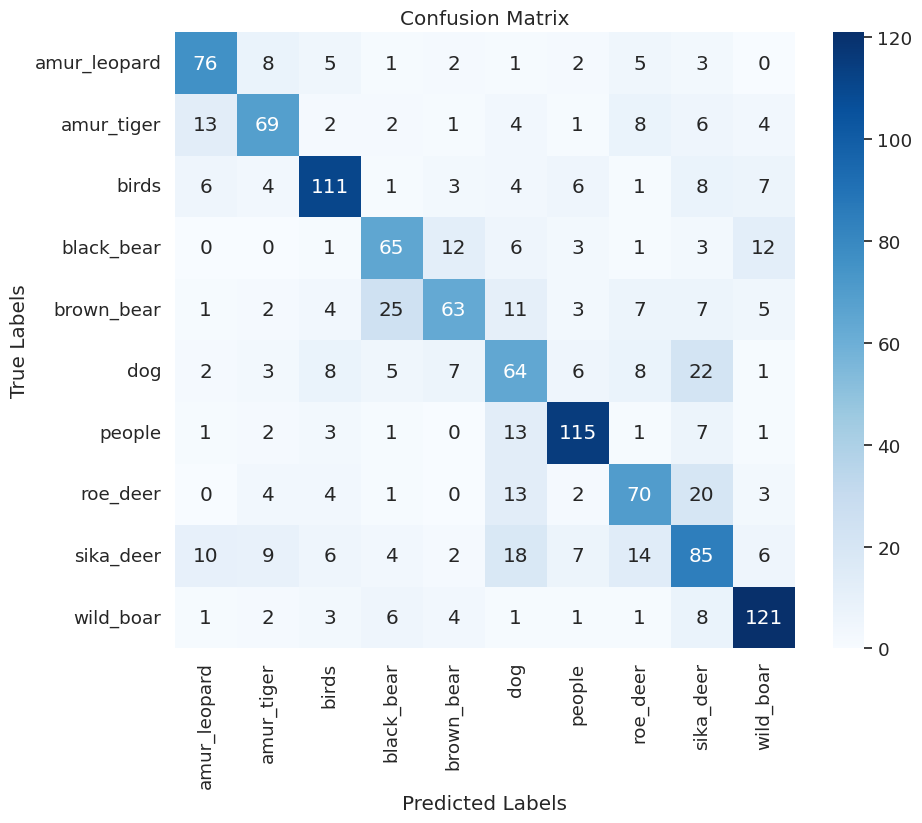

<Figure size 640x480 with 0 Axes>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def log_confusion_matrix(confusion_matrix, class_names, project_name, name):
    # Convert confusion matrix to a numpy array
    confusion_matrix_np = np.array(confusion_matrix)

    # Generate class labels in the correct order based on the confusion matrix
    class_labels = [str(i) for i in range(len(class_names))]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix_np, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Log confusion matrix as an image artifact
    with wandb.init(project=project_name, job_type="log_confusion_matrix") as run:
        wandb.log({f"confusion_matrix_{name}": wandb.Image(plt)}, commit=False)


log_confusion_matrix(CNN_confusion, class_names, "CV ASSIGNMENT 2", "CNN_confusion")




In [ ]:
class_names = [str(label) for label in class_to_label.keys()]

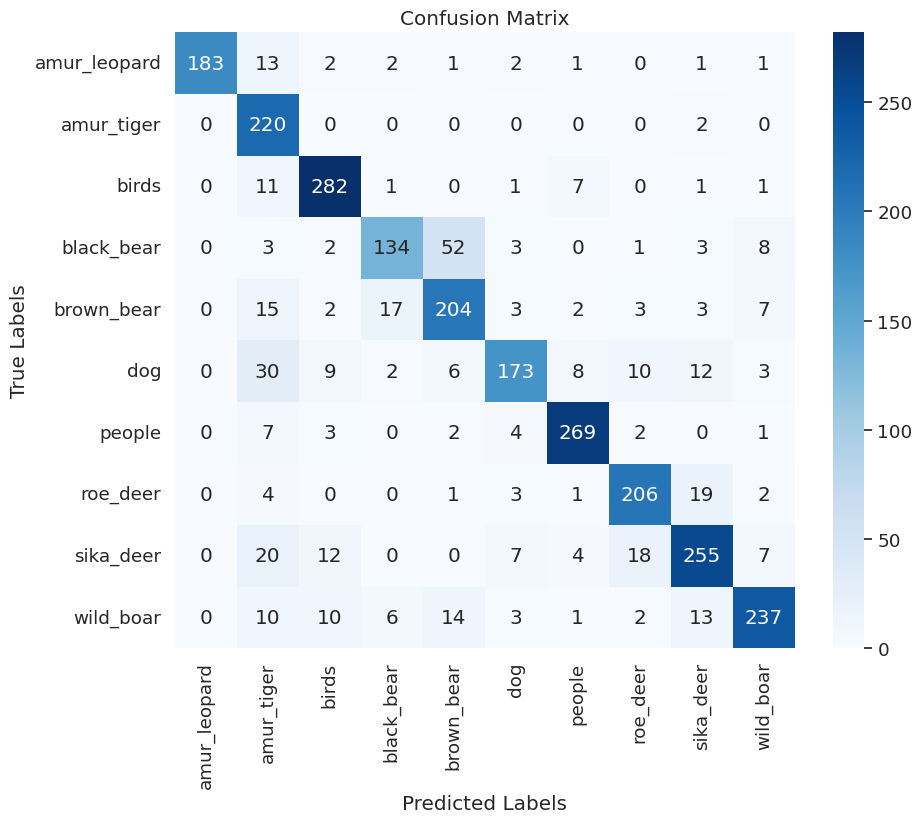

In [ ]:
log_confusion_matrix(Resnet_confusion, class_names,"CV ASSIGNMENT 2", "Resnet_confusion")

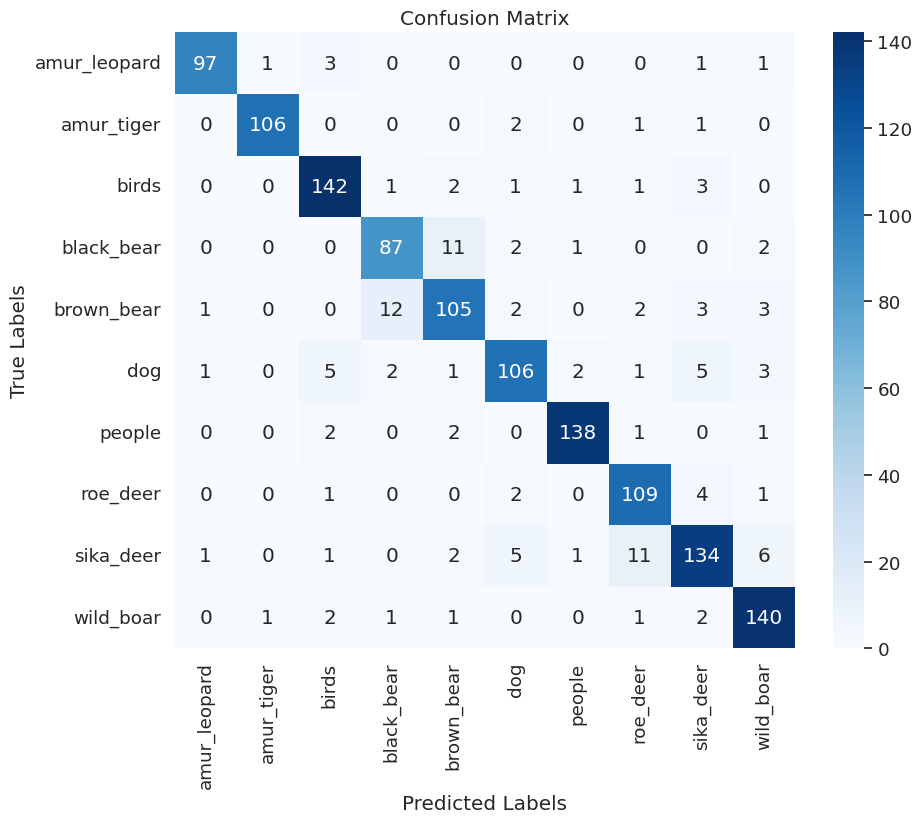

<Figure size 640x480 with 0 Axes>

In [ ]:
log_confusion_matrix(augmented_confusion, class_to_label,"CV ASSIGNMENT 2", "augmented_confusion")